In [0]:
from __future__ import print_function

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imutils.paths import list_images
from keras import backend as K
from keras.callbacks import CSVLogger
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from scipy.io import loadmat
from scipy.misc import imread
from skimage.io import imsave
from skimage.transform import resize

#from datasetutils.bsds500 import BSDS500
import BSDS500

target_size = (256, 256)

warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
K.set_image_data_format('channels_last') 



def get_scan(img_rows, img_cols, channels):
    inputs = Input((img_rows, img_cols, channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    
    model.compile(optimizer=Adam(lr=1e-3), 
                      loss='binary_crossentropy',
                      metrics=['binary_crossentropy'])


    return model

In [18]:
import BSDS500
TARGET_SHAPE = (256, 256)

bsds = BSDS500.BSDS500(target_size=TARGET_SHAPE)
ids, contours_train, sgmnts, train_images = bsds.get_train()
ids, contours_test, sgmnts, test_images = bsds.get_train()

C = np.concatenate([contours_test, contours_train])
I = np.concatenate([test_images, train_images])

csv_callback = CSVLogger('history.log', append=True)
scanner = get_scan(256, 256, 3)
H = scanner.fit(I, C, verbose=2, epochs=200, validation_split=0.1, callbacks=[csv_callback])

DOWNLOADING BSDS500 DATA BE PATIENT
/root/BSR
Train on 1956 samples, validate on 218 samples
Epoch 1/200
 - 102s - loss: 0.2030 - binary_crossentropy: 0.2030 - val_loss: 0.1697 - val_binary_crossentropy: 0.1697
Epoch 2/200
 - 82s - loss: 0.1520 - binary_crossentropy: 0.1520 - val_loss: 0.1397 - val_binary_crossentropy: 0.1397
Epoch 3/200
 - 82s - loss: 0.1391 - binary_crossentropy: 0.1391 - val_loss: 0.1322 - val_binary_crossentropy: 0.1322
Epoch 4/200
 - 82s - loss: 0.1317 - binary_crossentropy: 0.1317 - val_loss: 0.1284 - val_binary_crossentropy: 0.1284
Epoch 5/200
 - 83s - loss: 0.1297 - binary_crossentropy: 0.1297 - val_loss: 0.1263 - val_binary_crossentropy: 0.1263
Epoch 6/200
 - 83s - loss: 0.1253 - binary_crossentropy: 0.1253 - val_loss: 0.1227 - val_binary_crossentropy: 0.1227
Epoch 7/200
 - 82s - loss: 0.1227 - binary_crossentropy: 0.1227 - val_loss: 0.1215 - val_binary_crossentropy: 0.1215
Epoch 8/200
 - 83s - loss: 0.1192 - binary_crossentropy: 0.1192 - val_loss: 0.1344 - va

In [0]:
scanner = load_model('scanner.keras')
save_model(scanner, 'scanner.keras')

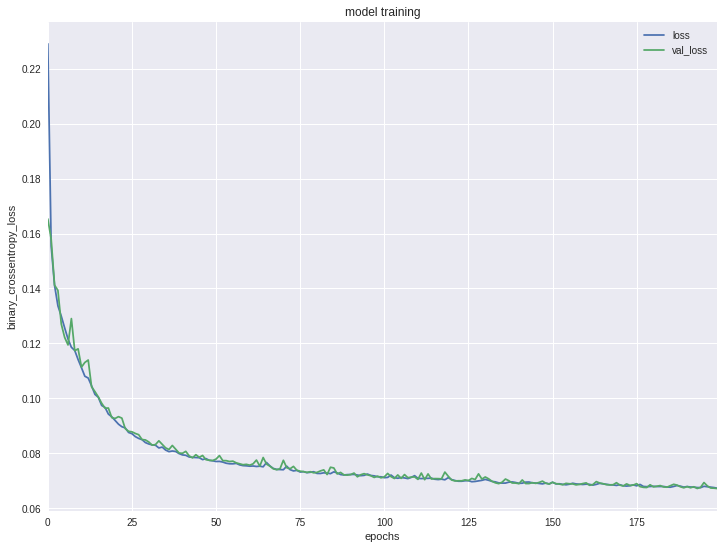

In [0]:
import seaborn
f = pd.DataFrame(H.history)[['loss','val_loss']].plot(figsize=(12,9))
plt.title('model training')
plt.ylabel('binary_crossentropy_loss')
plt.xlabel('epochs')